# Feedforward Neural Networks

Read csv into pandas dataframe

In [2]:
import pandas as pd

df = pd.read_csv('imdb-reviews.csv', sep='\t')

Create functions used for data cleaning and apply them to our dataframe.

The function data_preprocessing() can be used for any dataframe we want to preprocess/transform later.

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords

def rate_to_pos_neg(row):
  if row['rating'] <= 4:
    return 0
  elif row['rating'] >= 7:
    return 1

def data_preprocessing(df):

  stop = set(stopwords.words('english'))

  df['reviews_edited'] = df['review'].str.lower() # lowercase

  # lemmatize text to group together the different inflected forms of a word so they can be analyzed as a single item
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()

  def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

  df['reviews_edited'] = df['reviews_edited'].apply(lemmatize_text)

  df['reviews_edited'] = df['reviews_edited'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stopwords
  df['reviews_edited'] = df['reviews_edited'].str.replace("n\'t", " not", regex=True) # replace n't with not
  df['reviews_edited'] = df['reviews_edited'].str.replace(r'<br />', ' ', regex=True) # remove html break lines
  df["reviews_edited"] = df['reviews_edited'].str.replace('[^\w\s]','', regex=True) # remove punctuation

  df['target'] = df.apply(rate_to_pos_neg, axis=1)

  return df

df = data_preprocessing(df)

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,url,rating,review,reviews_edited,target
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,thought wa quiet good movie wa fun watch it li...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,wagon master unique film amongst john fords wo...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,film ha near perfect film john ford made film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,gave 4 star ha lot interesting theme many alre...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,movie really genuine random really hard find m...,1
...,...,...,...,...,...
45003,http://www.imdb.com/title/tt0449000/usercomments,1.0,I don't even know where to begin...<br /><br /...,even know begin its worth typing review quote...,0
45004,http://www.imdb.com/title/tt0109382/usercomments,1.0,One of the worst movies I saw in the 90s. I'd ...,one worst movie saw 90s id often use benchmark...,0
45005,http://www.imdb.com/title/tt0375560/usercomments,1.0,Baldwin has really stooped low to make such mo...,baldwin ha really stooped low make movies scri...,0
45006,http://www.imdb.com/title/tt0165107/usercomments,1.0,If you liked watching Mel Gibson in Million Do...,liked watching mel gibson million dollar hotel...,0


Create x, y datasets based on the features we need.

In [4]:
df = df[['reviews_edited', 'target']]
x = df[['reviews_edited']]
y = df[['target']]
df

,reviews_edited,target
0,thought wa quiet good movie wa fun watch it li...,1
1,wagon master unique film amongst john fords wo...,1
2,film ha near perfect film john ford made film ...,1
3,gave 4 star ha lot interesting theme many alre...,0
4,movie really genuine random really hard find m...,1
...,...,...
45003,even know begin its worth typing review quote...,0
45004,one worst movie saw 90s id often use benchmark...,0
45005,baldwin ha really stooped low make movies scri...,0
45006,liked watching mel gibson million dollar hotel...,0


Split into train and valitation datasets with 80% and 20% proportion of the whole dataset respectively.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(x, np.ravel(y), test_size=0.2, random_state=42)

Download glove embeddings from Stanford, if they are not already downloaded.

In [6]:
from pathlib import Path

if not Path("glove.6B.50d.txt").is_file():
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove*.zip

Create a dictionary from glove embeddings, containing the words as keys and their vectors as values.

In [7]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

w2v_dict = {}

vector_length = 0
for word_vector_pair in w2v[1:]:  # first line contains dimension info
    word_vector_pair = word_vector_pair.split()
    word = word_vector_pair[0]
    vector = word_vector_pair[1:]
    w2v_dict[word] = np.array(vector, dtype=float)
    vector_length = len(vector)

w2v_dict['<unk>'] = [0 for i in range(vector_length)] # vector for unknown token if full of 0s

Create a custom Dataset class which inherits the Dataset class of torch.utils.data and creates a dataset using the glove embeddings described earlier. For each review, we get the vector of each word and average the values for each dimension of the vectors respectively. The result when regarding a set of reviews, instead of a single review, is a 2d array.

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

  def __init__(self, x_dataset, y_dataset, max_dimension, use_padding=True, reduction='average'):

    self.labels = y_dataset
    self.array = np.array([])
    array = []
    for review in x_dataset.reviews_edited:
      review = review.split()
      review_averaged_vectors = []
      for word in review:
        review_averaged_vectors.append(w2v_dict[word] if word in w2v_dict else w2v_dict['<unk>'])

      array.append(np.mean(review_averaged_vectors, axis=0))
    
    self.array = np.array(array, dtype=object).astype(float)

  def __getitem__(self, idx):
    return torch.tensor(self.array[idx], dtype=torch.float), torch.tensor(self.labels[idx])

  def len(self):
    return self.array.shape[0]

  def __len__(self):
    return self.array.shape[0]

  def get_vectors(self):
    return self.array

  def get_labels(self):
    return self.labels

Create a train and validation dataset using the class we previously defined and the train and validation data we previously splitted.

In [9]:
train_dataset = CustomDataset(x_train, y_train, vector_length)
validation_dataset = CustomDataset(x_val, y_val, vector_length)
print(train_dataset.len())
print(validation_dataset.len())

36006
9002


Get x and y dimensions for train and validation datasets as tensors containing the vectors as they have been produced by the previous transformation to custom datasets. This replaces the previously produced `x_train`, `y_train`, `x_val` and `y_val` by `train_test_split()`, since we no longer need these variables as simple non-tensor arrays or strings.

In [10]:
x_train, y_train = torch.tensor(train_dataset.get_vectors(), dtype=torch.float), torch.tensor(train_dataset.get_labels())
x_val, y_val = torch.tensor(validation_dataset.get_vectors(), dtype=torch.float), torch.tensor(validation_dataset.get_labels())
print(x_val.size(), y_val.size())

torch.Size([9002, 300]) torch.Size([9002])


Define the dimensions for our neural networks. For our problem, after experimentation with variable values for each hyperparameter, it was found that the following hyperparameters produced the best results.

The dimension of the hidden layers needs to be big enough to model the problem, but not very large, so as to prevent delays in training, and overfitting.

Batch size needs to be big enough so that we avoid noise, but small enough to allow the model to be trained fast, while using less memory. This number is usually near the square root of the dataset size (for our case, the train dataset size is ca. 36000).

Learning rate of 10e4 is pretty standard in the majority of such problems.

In [11]:
device = torch.device("cpu")

d_embedding = vector_length
d_hidden = 128
batch_size = 256
learning_rate = 0.0001
num_epochs = 50
num_classes = 2

Our first neural network consists of just one linear layer and an optional activation function.

In [12]:
import torch.nn as nn

class Net1(nn.Module):
    def __init__(self, d_emb, num_classes, activation=None):
        super(Net1, self).__init__()

        self.linear1 = nn.Linear(d_emb, num_classes)
        self.activation = activation

    def forward(self, x):
        out = self.linear1(x)

        if self.activation:
            out = self.activation(out) 

        return out

Our second neural network consists of two linear layers, a Rectified Linear Unit (ReLU) activation function between them, and an optional activation function at the end.

In [13]:
class Net2(nn.Module):
    def __init__(self, d_emb, d_hidden, num_classes, activation=None):
        super(Net2, self).__init__()

        self.linear1 = nn.Linear(d_emb, d_hidden)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden, num_classes)
        self.activation = activation

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)

        if self.activation:
            out = self.activation(out)

        return out

Our third neural network consists of three linear layers, a Hyperbolic Tangent activation function between them, and an optional activation function at the end.

In [14]:
class Net3(nn.Module):
    def __init__(self, d_emb, d_hidden, num_classes, activation=None):
        super(Net3, self).__init__()

        self.linear1 = nn.Linear(d_emb, d_hidden)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(d_hidden, d_hidden)
        self.linear3 = nn.Linear(d_hidden, num_classes)
        self.activation = activation

    def forward(self, x):
        out = self.linear1(x)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.tanh(out)
        out = self.linear3(out)

        if self.activation:
            out = self.activation(out)

        return out

Create dataloader to use for the training of the models, later.

In [15]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

The following function helps us train each of the previous defined models, export statistics about their scores and plot them.

In [16]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, num_epochs, train_dataloader, criterion, optimizer):
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []
  train_f1 = []
  val_f1 = []
  for epoch in range(num_epochs):
    for i, (reviews, labels) in enumerate(train_dataloader):

      # Forward pass
      outputs = model(reviews)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # statistics calculation
    train_outputs = model(x_train)
    loss = criterion(train_outputs, y_train)
    train_loss.append(loss.item())
    train_accuracy.append(accuracy_score(y_train, train_outputs.argmax(1)))
    train_precision.append(precision_score(y_train, train_outputs.argmax(1)))
    train_recall.append(recall_score(y_train, train_outputs.argmax(1)))
    train_f1.append(f1_score(y_train, train_outputs.argmax(1)))

    val_outputs = model(x_val)
    loss = criterion(val_outputs, y_val)    
    val_loss.append(loss.item())
    val_accuracy.append(accuracy_score(y_val, val_outputs.argmax(1)))
    val_precision.append(precision_score(y_val, val_outputs.argmax(1)))
    val_recall.append(recall_score(y_val, val_outputs.argmax(1)))
    val_f1.append(f1_score(y_val, val_outputs.argmax(1)))

  # plots / learning curves
  fig, axs = plt.subplots(2, 3, figsize=(15, 7))
  fig.patch.set_facecolor('white')

  axs[0, 0].plot(range(num_epochs), train_loss, label="train set")
  axs[0, 0].plot(range(num_epochs), val_loss, label="validation set")
  axs[0, 0].set_title('Cross Entropy Loss')
  axs[0, 0].set_ylim([0.3, 0.8])
  
  axs[0, 1].plot(range(num_epochs), train_accuracy, label="train set")
  axs[0, 1].plot(range(num_epochs), val_accuracy, label="validation set")
  axs[0, 1].set_title('Accuracy')
  axs[0, 1].set_ylim([0.65, 0.9])

  axs[0, 2].plot(range(num_epochs), train_precision, label="train set")
  axs[0, 2].plot(range(num_epochs), val_precision, label="validation set")
  axs[0, 2].set_title('Precision')
  axs[0, 2].set_ylim([0.65, 0.9])

  axs[1, 0].plot(range(num_epochs), train_recall, label="train set")
  axs[1, 0].plot(range(num_epochs), val_recall, label="validation set")
  axs[1, 0].set_title('Recall')
  axs[1, 0].set_ylim([0.65, 0.9])

  axs[1, 1].plot(range(num_epochs), train_f1, label="train set")
  axs[1, 1].plot(range(num_epochs), val_f1, label="validation set")
  axs[1, 1].set_title('F1')
  axs[1, 1].set_ylim([0.65, 0.9])

  # roc curve
  probabilities = F.softmax(val_outputs, dim=1)[:, 1]
  y_score = probabilities.detach().numpy()
  nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_val, y_score)
  roc_auc = auc(nn_fpr, nn_tpr)

  axs[1, 2].plot(nn_fpr,nn_tpr, label="validation set")
  axs[1, 2].set_title('ROC Curve')
  axs[1, 2].set_ylim([0, 1])
  axs[1, 2].set_xlim([0, 1])
  axs[1, 2].set_ylabel('True Positive Rate')
  axs[1, 2].set_xlabel('False Positive Rate' )
  axs[1, 2].text(0.8, 0.2, 'AUC: '+str(round(roc_auc, 2)), horizontalalignment='center', verticalalignment='center', transform=axs[1, 2].transAxes)

  axs[0][0].legend()
  axs[0][1].legend()
  axs[0][2].legend()
  axs[1][0].legend()
  axs[1][1].legend()
  axs[1][2].legend()

  return train_outputs.argmax(1), val_outputs.argmax(1)

Train the first neural network and print its statistics (Precision, Recall, F1-Score) while testing in both the training set and the validation set. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model. The roc curve also depicts a very good model, with large area under the curve (AUC) of about 0.91, showing a decent rate of false positives and false negatives and a good balance between them.

Even though the previously defined number of epochs is 50, this very simple model converges to a good solution slowly, so we will manually input its number of epochs to 200, in order to observe its behaviour more extensively.

Train set:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     17950
           1       0.83      0.83      0.83     18056

    accuracy                           0.83     36006
   macro avg       0.83      0.83      0.83     36006
weighted avg       0.83      0.83      0.83     36006

Validation set:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      4550
           1       0.83      0.84      0.83      4452

    accuracy                           0.83      9002
   macro avg       0.83      0.83      0.83      9002
weighted avg       0.83      0.83      0.83      9002



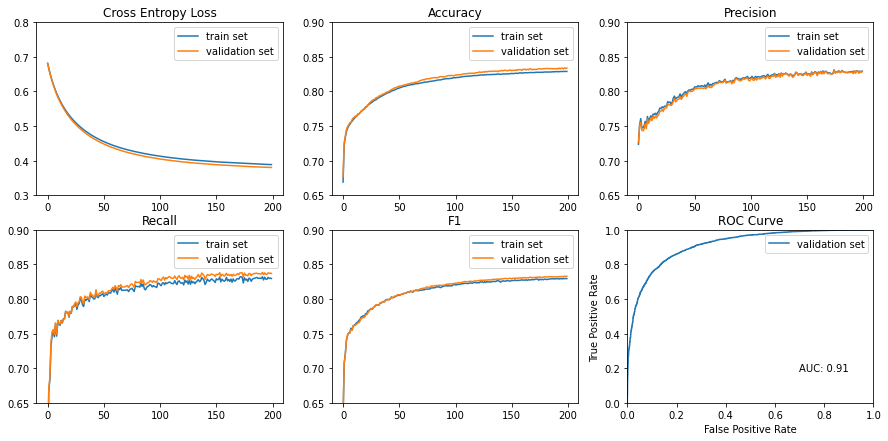

In [17]:
from sklearn.metrics import classification_report

model1 = Net1(d_emb=d_embedding, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate) 

train_outputs, val_outputs = train_model(model1, 200, train_dataloader, criterion, optimizer)

print("Train set:\n", classification_report(y_train, train_outputs))
print("Validation set:\n", classification_report(y_val, val_outputs))

Train the second neural network and print its statistics (Precision, Recall, F1-Score) while testing in both the training set and the validation set. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model. The roc curve also depicts a very good model, with large area under the curve (AUC) of about 0.92, showing a decent rate of false positives and false negatives and a good balance between them.

We can easily observe that this, more complex model, performs slightly better than the first one.

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     17950
           1       0.84      0.84      0.84     18056

    accuracy                           0.84     36006
   macro avg       0.84      0.84      0.84     36006
weighted avg       0.84      0.84      0.84     36006

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4550
           1       0.84      0.83      0.84      4452

    accuracy                           0.84      9002
   macro avg       0.84      0.84      0.84      9002
weighted avg       0.84      0.84      0.84      9002



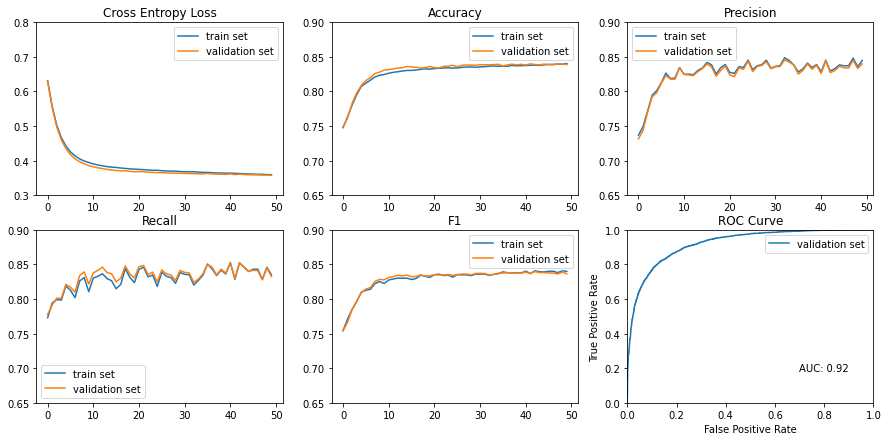

In [18]:
model2 = Net2(d_emb=d_embedding, d_hidden=d_hidden, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train_outputs, val_outputs = train_model(model2, num_epochs, train_dataloader, criterion, optimizer)

print(classification_report(y_train, train_outputs))
print(classification_report(y_val, val_outputs))

Train the third neural network and print its statistics (Precision, Recall, F1-Score) while testing in both the training set and the validation set. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model. The roc curve also depicts a very good model, with large area under the curve (AUC) of about 0.92, showing a decent rate of false positives and false negatives and a good balance between them.

We can easily observe that this, even more complex model, converges to a good solution faster than the previous one, but has no performance improvement. This way, we can assume that more layers of the same type do not help us solve this problem better.

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     17950
           1       0.84      0.84      0.84     18056

    accuracy                           0.84     36006
   macro avg       0.84      0.84      0.84     36006
weighted avg       0.84      0.84      0.84     36006

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4550
           1       0.83      0.84      0.84      4452

    accuracy                           0.84      9002
   macro avg       0.84      0.84      0.84      9002
weighted avg       0.84      0.84      0.84      9002



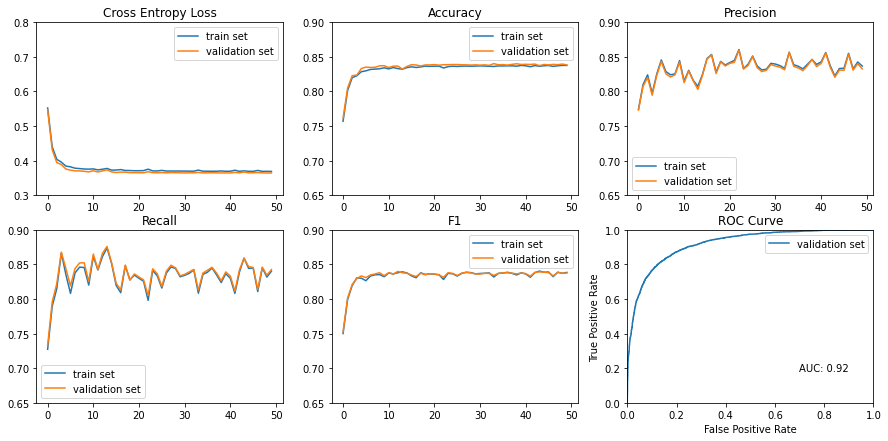

In [19]:
model3 = Net3(d_emb=d_embedding, d_hidden=d_hidden, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

train_outputs, val_outputs = train_model(model3, num_epochs, train_dataloader, criterion, optimizer)

print(classification_report(y_train, train_outputs))
print(classification_report(y_val, val_outputs))

Section for testing with a new test dataset given by the user. Just insert the path of your test csv file in the `path_to_your_test_set` variable and run the code (while having already run the code written before this message).
After running the following code, a classification report providing precision, recall and F-measure for your test set will be printed on the screen.

In [ ]:
#########################################
############# YOUR TEST SET #############
#########################################

path_to_your_test_set = 'path'

df_test = pd.read_csv(path_to_your_test_set, sep='\t')

df_test = data_preprocessing(df_test)

df_test = df_test[['reviews_edited', 'target']]
x = df_test[['reviews_edited']]
y = np.ravel(df_test[['target']])

test_dataset = CustomDataset(x, y, vector_length)

x_test, y_test = torch.tensor(test_dataset.get_vectors(), dtype=torch.float), torch.tensor(test_dataset.get_labels())

test_outputs = model2(x_test)

test_outputs = test_outputs.argmax(1)

print(classification_report(y_test, test_outputs))